# Forecasting for the Exogenous Variables

In order for the ARIMAX model to provide a great forecasting, it depends on the exogenous variable. However the exogenous variables must also be forecasted in order to fill the gap.

___
Initialize the required function for data processing

Load the necessary libraries

In [ ]:
import warnings
warnings.filterwarnings("ignore", message="No frequency information was provided, so inferred frequency MS will be used")


In [2]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

load the dataset

In [3]:
df = pd.read_csv('dataset.csv', index_col='Month', parse_dates=True,date_parser=lambda x: pd.to_datetime(x, format='%y-%b'))


In [4]:
# Initialise for future use

production = df['Production']
withdrawals = df['Withdrawals']
globalPrice = df['GlobalPrice']
exchangeRate = df['ExchangeRate']
temperature = df['TempMax']
precipitation = df['Precipitation']

In [5]:
# ADF test for stationarity

def ADF_test(df):
    p = adfuller(df)[1]
    print(f'P-value: {p} < 0.05')
    if p < 0.05:
        print('The time series is stationary')
    else:
        print('The time series is not stationary')

In [6]:
# Optional Differencing

def Differencing(df, lags):
    df_diff = df.diff(lags).dropna()
    df_diff.plot(), ADF_test(df_diff)

In [7]:
# Train test Split

def train_test_split(df, test_size):
    total = len(df)
    train_size = int(total - test_size)

    train = df.iloc[:train_size]
    test = df.iloc[train_size:]

    return train, test

In [8]:
# example of train test split
train, test = train_test_split(production, 24)

### ACF and PACF

The ACF and PACF are essential for find the AR and MA component of the ARIMA.

Criteria:

For AR(p)
- Based on PACF
- The ACF should show a smooth decay approaching zero
- The PACF should show a cut off (rapid drop)

For MA(q)
- Based on ACF
- The PACF should show a smooth decay approaching zero
- The ACF should show a cut off

In [9]:
def ACF_PACF(df, lags):
    plot_acf(df, lags=lags);
    plot_pacf(df, lags=lags);

### Modelling


#### Finding the best order

In [10]:
# Finding the best order using RMSE

def Order_RMSE(train, test, p_range, d_range, q_range):
    best_score, best_order = float("inf"), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    predicted = model_fit.forecast(steps=len(test))
                    rmse = ((predicted - test) ** 2).mean() ** 0.5
                    if rmse < best_score:
                        best_score, best_order = rmse, order
                except:
                    continue
    print(f'Best ARIMA{best_order} RMSE={best_score}')

In [11]:
# Finding the best order using AIC 

def Order_AIC(train, test, p_range, d_range, q_range):
    best_score, best_order = float("inf"), None
    for p in p_range:
        for d in d_range:
            for q in q_range:
                order = (p,d,q)
                try:
                    model = ARIMA(train, order=order)
                    model_fit = model.fit()
                    aic = model_fit.aic
                    if aic < best_score:
                        best_score, best_order = aic, order
                except:
                    continue
    print(f'Best ARIMA{best_order} AIC={best_score}')

#### Test the Model

In [12]:
# Modelling 

def Model(train, test, order):
    model = ARIMA(train, order=order).fit()

    start = len(train)
    end = start + len(test) - 1

    pred= model.predict(start=start, end=end, typ='levels', dynamic=False).rename('Forecast')

    pred.plot(legend=True)
    test.plot(legend=True)

    # Compare the forecast with the test set
    pred.apply(lambda x: f"{x:.2f}")
    for i in range(len(pred)):
        print(f'Actual: {test[i]}, Predicted: {pred[i]}')

    return model
    

In [13]:
def Predict(train, order, months):
    model = ARIMA(train, order=order).fit()
    pred=model.forecast(steps=months).rename('Predict')
    return pred

# I use this for debugging

#### Evaluation

In [14]:
# Evaluate the model using AIC, BIC, MSE, RMSE, MAE, MAPE

def Evaluate(train, test, order):
    model = ARIMA(train, order=order).fit()
    pred = model.predict(start=len(train), end=len(train) + len(test) - 1, typ='levels', dynamic=False).rename('Forecast')

    mse = ((pred - test) ** 2).mean()
    rmse = mse ** 0.5
    mae = (abs(pred - test)).mean()
    mape = (abs(pred - test) / abs(test)).mean() * 100

    print(f'Evaluation of ARIMA{order}')
    print(f'MSE: {mse}')
    print(f'MAE: {mae}')
    print(f'RMSE: {rmse}')
    print(f'MAPE: {mape}')
    print(f'AIC: {model.aic}')
    print(f'BIC: {model.bic}')


### Forecasting

In [15]:
# Forecasting 

def Forecast(df, order, months):

    final_model = ARIMA(df, order = order).fit()
    forecast = final_model.forecast(steps=months).rename('Forecast')
    # forecast.apply(lambda x: f"{x:.2f}")
    
    return forecast, final_model

In [16]:
def Forecasted_plot(actual, forecasted):
    plt.figure(figsize=(12, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(forecasted, label='Forecasted', color='red')
    plt.title('Forecast vs Actual')
    plt.legend()
    plt.show()

___


# Production


<Axes: xlabel='Month'>

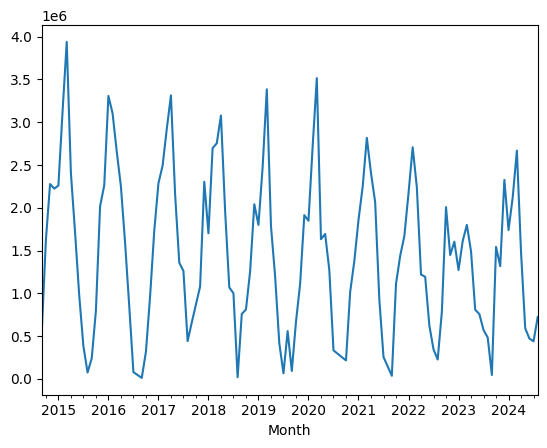

In [17]:
production.plot()

In [18]:
ADF_test(production)

P-value: 0.2760270877045634 < 0.05
The time series is not stationary


P-value: 2.9231354145461644e-15 < 0.05
The time series is stationary


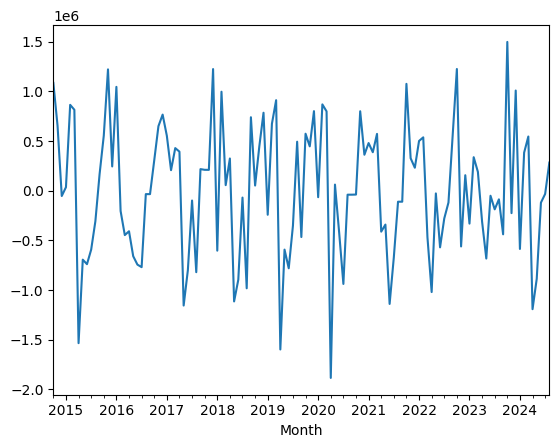

In [19]:
Differencing(production, 1)

In [20]:
prod_train, prod_test = train_test_split(production, 24)

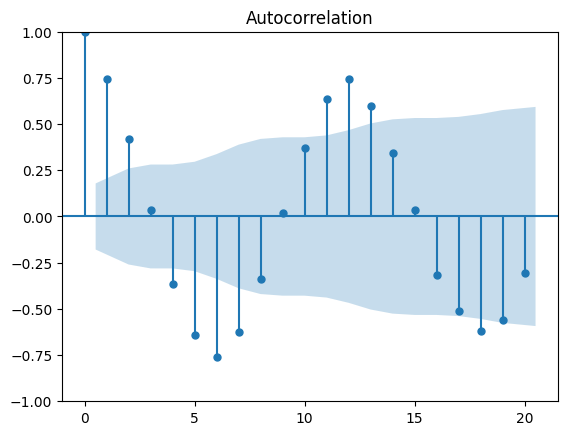

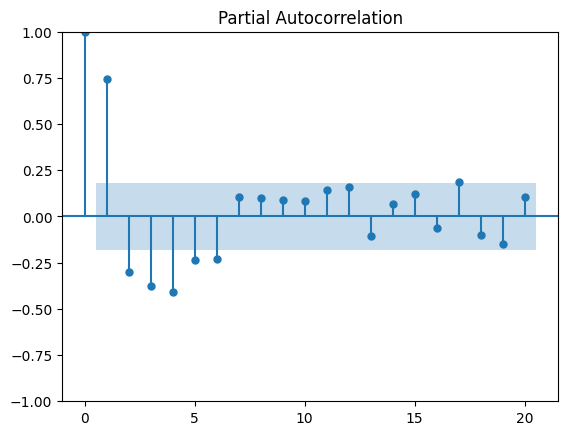

In [21]:
ACF_PACF(production, 20)

In [22]:
Order_RMSE(prod_train, prod_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(prod_train, prod_test, range(0, 5), range(0, 2), range(0, 5))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(4, 1, 2) RMSE=440829.6573419902


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(3, 1, 4) AIC=2746.9334568906324


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Actual: 782119.0, Predicted: 24870.89279973955
Actual: 2007522.0, Predicted: 428886.51658830716
Actual: 1446898.0, Predicted: 1002244.7410335226
Actual: 1603146.0, Predicted: 1699513.6969638257
Actual: 1272210.0, Predicted: 2257327.768095648
Actual: 1610065.0, Predicted: 2584875.0643501943
Actual: 1800101.0, Predicted: 2553569.28861591
Actual: 1489215.0, Predicted: 2202555.820342993
Actual: 806884.0, Predicted: 1602897.9115433763
Actual: 756657.5, Predicted: 930315.2820607966
Actual: 569482.0, Predicted: 351455.03555931547
Actual: 482943.5, Predicted: 28657.541541036102
Actual: 44419.0, Predicted: 41032.731643906445
Actual: 1542323.0, Predicted: 389722.79833725875
Actual: 1316907.0, Predicted: 978495.5901594765
Actual: 2325542.0, Predicted: 1653374.7064352646
Actual: 1739690.0, Predicted: 2233311.125885649
Actual: 2122968.0, Predicted: 2565758.478101425
Actual: 2668661.0, Predicted: 2561668.4649102893
Actual: 1476667.0, Predicted: 2223090.1823568703
Actual: 590428.0, Predicted: 1639628

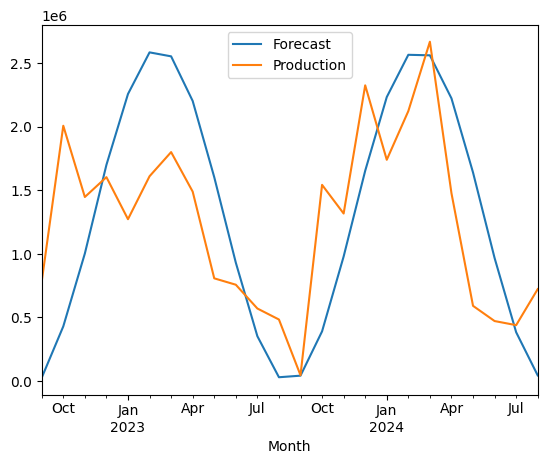

In [23]:
prod_model = Model(prod_train, prod_test, (3,1,4))

In [24]:
Evaluate(prod_train, prod_test, (3,1,4))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluation of ARIMA(3, 1, 4)
MSE: 495908106641.7249
MAE: 590917.3543039934
RMSE: 704207.4315439485
MAPE: 55.18445430007496
AIC: 2746.9334568906324
BIC: 2767.364472023437


In [25]:
Evaluate(prod_train, prod_test, (4,1,2))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


Evaluation of ARIMA(4, 1, 2)
MSE: 194330786792.2565
MAE: 336992.53605986113
RMSE: 440829.6573419902
MAPE: 77.97348281405328
AIC: 2757.6590783437655
BIC: 2775.536216584969


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


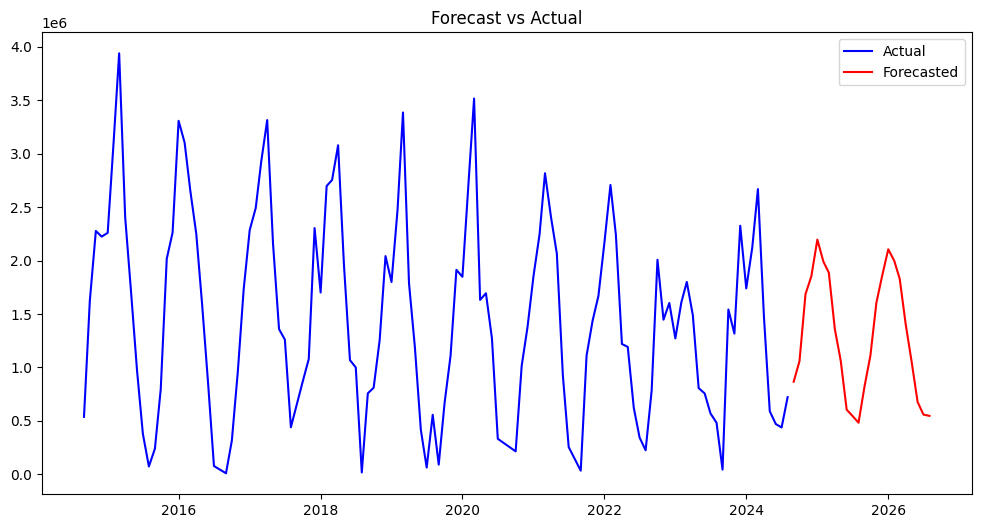

2024-09-01     866630.41
2024-10-01    1058314.13
2024-11-01    1686063.09
2024-12-01    1852407.30
2025-01-01    2196089.08
2025-02-01    1990321.71
2025-03-01    1886639.38
2025-04-01    1358794.49
2025-05-01    1067038.65
2025-06-01     604585.67
2025-07-01     546052.30
2025-08-01     482890.76
2025-09-01     824626.72
2025-10-01    1110180.20
2025-11-01    1606706.63
2025-12-01    1860633.14
2026-01-01    2105366.74
2026-02-01    1997051.97
2026-03-01    1828076.26
2026-04-01    1400578.10
2026-05-01    1057561.16
2026-06-01     677208.44
2026-07-01     558993.85
2026-08-01     546959.09
Freq: MS, Name: Forecast, dtype: object

In [26]:
forecast, model = Forecast(production, (3,1,4), 24)
Forecasted_plot(production, forecast)
forecast.apply(lambda x: f"{x:.2f}")

# Withdrawals

<Axes: xlabel='Month'>

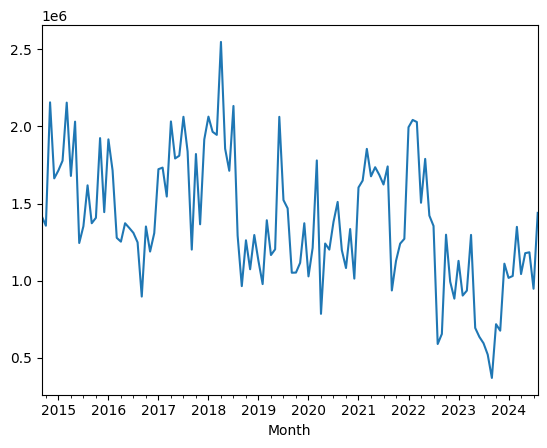

In [27]:
withdrawals.plot()

In [28]:
ADF_test(withdrawals)

P-value: 0.2252467834044763 < 0.05
The time series is not stationary


P-value: 0.019063452229377265 < 0.05
The time series is stationary


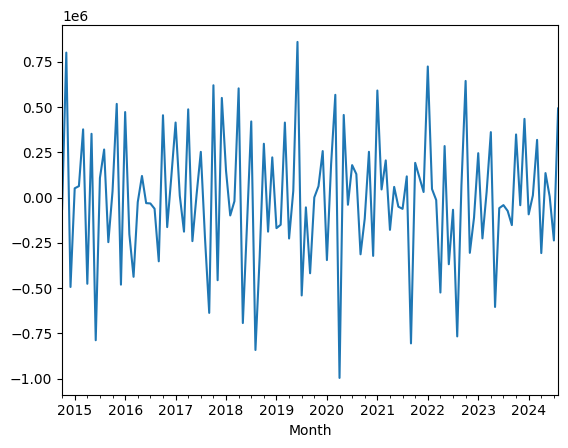

In [29]:
Differencing(withdrawals, 1)

In [30]:
with_train, with_test = train_test_split(withdrawals, 24)

In [31]:
ADF_test(with_train)

P-value: 0.2105189930767179 < 0.05
The time series is not stationary


P-value: 0.03299407455420619 < 0.05
The time series is stationary


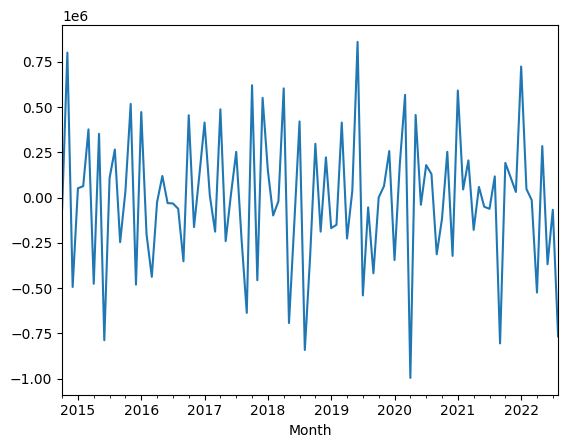

In [32]:
Differencing(with_train, 1)

In [33]:
Order_RMSE(with_train, with_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(with_train, with_test, range(0, 5), range(0, 2), range(0, 5))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(0, 1, 1) RMSE=279121.0998670923


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(4, 1, 4) AIC=2685.300398895743


In [34]:
Evaluate(with_train, with_test, (0,1,1))
Evaluate(with_train, with_test, (4,1,4))

Evaluation of ARIMA(0, 1, 1)
MSE: 77908588391.01534
MAE: 233361.35916388597
RMSE: 279121.0998670923
MAPE: 30.160733848719328
AIC: 2699.1508683714133
BIC: 2704.2586221546144


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Evaluation of ARIMA(4, 1, 4)
MSE: 250943686596.5909
MAE: 423287.63131392514
RMSE: 500942.79772903305
MAPE: 60.864366972755846
AIC: 2685.300398895743
BIC: 2708.285290920148


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Actual: 653106, Predicted: 869979.0592619035
Actual: 1297513, Predicted: 1038418.0785277623
Actual: 992443, Predicted: 1144622.386552462
Actual: 882287, Predicted: 1083913.2918055158
Actual: 1127713, Predicted: 1405287.7818833888
Actual: 902429, Predicted: 1191995.2866648736
Actual: 934551, Predicted: 1346869.4256567433
Actual: 1296228, Predicted: 1409136.1663724117
Actual: 692246, Predicted: 1332163.3894548381
Actual: 634228, Predicted: 1357137.1277910175
Actual: 592765, Predicted: 1504673.1403067356
Actual: 519388, Predicted: 1291940.8440431906
Actual: 367692, Predicted: 1462987.2753536573
Actual: 716481, Predicted: 1452105.0048354685
Actual: 674464, Predicted: 1347502.5312720835
Actual: 1109465, Predicted: 1455297.9680598164
Actual: 1017046, Predicted: 1472629.6909442348
Actual: 1029578, Predicted: 1324005.1589380242
Actual: 1348478, Predicted: 1508357.4757293384
Actual: 1042072, Predicted: 1422211.0117193095
Actual: 1177536, Predicted: 1363108.5588335798
Actual: 1183388, Predicted:

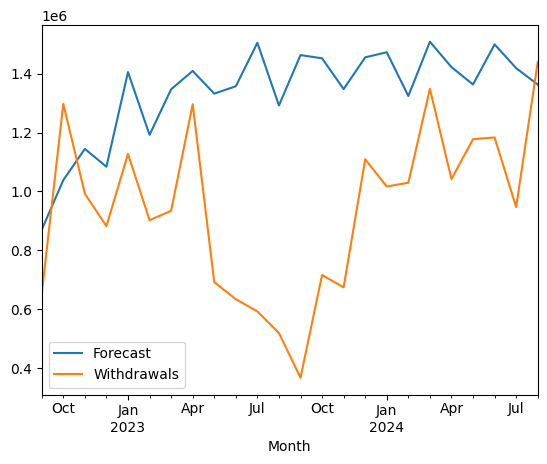

In [35]:
Model(with_train, with_test, (4,1,4))

In [36]:
Evaluate(with_train, with_test, (4,1,4))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluation of ARIMA(4, 1, 4)
MSE: 250943686596.5909
MAE: 423287.63131392514
RMSE: 500942.79772903305
MAPE: 60.864366972755846
AIC: 2685.300398895743
BIC: 2708.285290920148


In [37]:
Evaluate(with_train, with_test, (2,1,1))

Evaluation of ARIMA(2, 1, 1)
MSE: 90946054189.95503
MAE: 262215.640862692
RMSE: 301572.63501510717
MAPE: 30.388969774420044
AIC: 2701.8520717393235
BIC: 2712.0675793057258


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


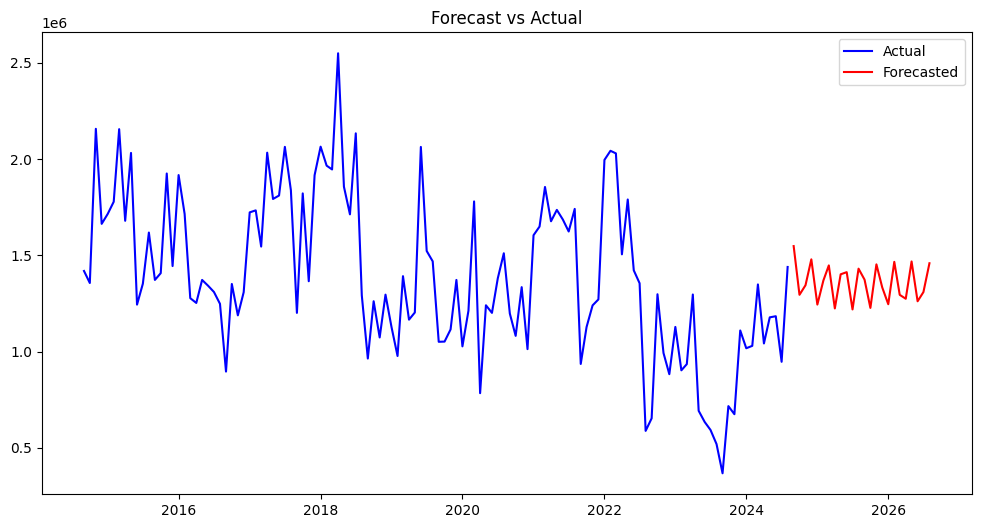

In [38]:
forecast, model = Forecast(withdrawals, (4,1,4), 24)
Forecasted_plot(withdrawals, forecast)

# Global Price

<Axes: xlabel='Month'>

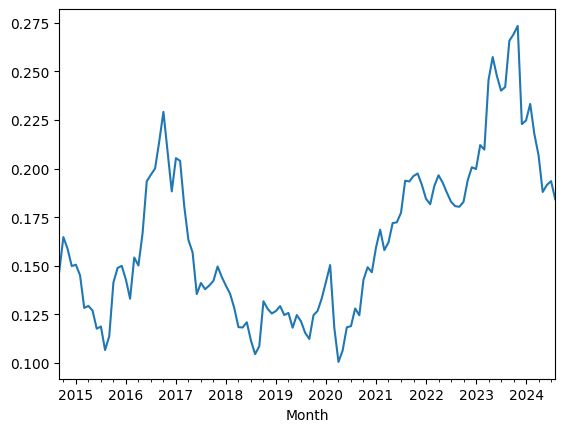

In [39]:
globalPrice.plot()

In [40]:
ADF_test(globalPrice)

P-value: 0.39893074883281937 < 0.05
The time series is not stationary


P-value: 9.25343456590585e-13 < 0.05
The time series is stationary


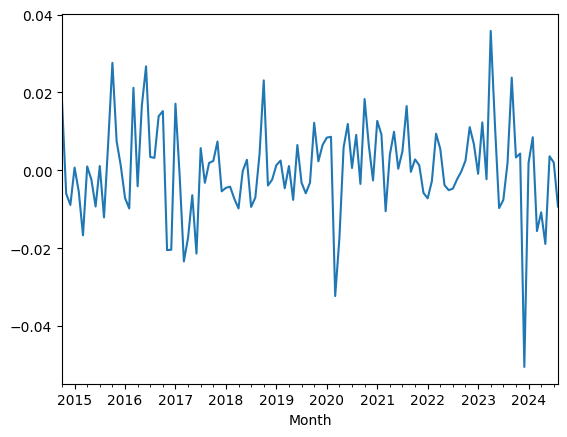

In [41]:
Differencing(globalPrice, 1)

In [42]:
gPrice_train, gPrice_test = train_test_split(globalPrice, 24)
ADF_test(gPrice_train)

P-value: 0.26869309208945824 < 0.05
The time series is not stationary


P-value: 7.963750641682842e-05 < 0.05
The time series is stationary


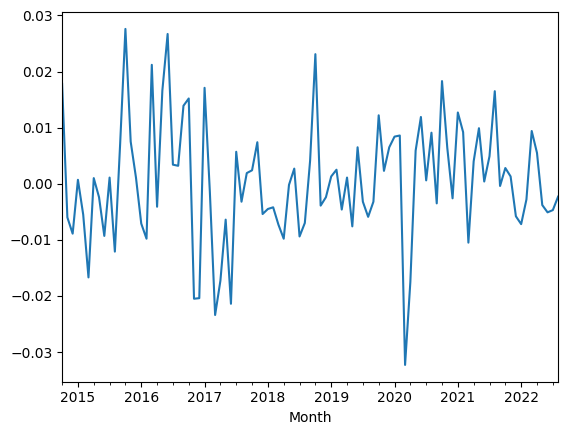

In [43]:
Differencing(gPrice_train, 1)

In [44]:
Order_RMSE(gPrice_train, gPrice_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(gPrice_train, gPrice_test, range(0, 5), range(0, 2), range(0, 5))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(2, 1, 3) RMSE=0.047775565318932185


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(4, 0, 0) AIC=-598.1064376647086


In [45]:
Evaluate(gPrice_train, gPrice_test, (2,1,3))
Evaluate(gPrice_train, gPrice_test, (4,0,0))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\stat

Evaluation of ARIMA(2, 1, 3)
MSE: 0.002282504641543556
MAE: 0.03815777488830355
RMSE: 0.047775565318932185
MAPE: 15.949135669012435
AIC: -593.6454644793084
BIC: -578.3222031297051
Evaluation of ARIMA(4, 0, 0)
MSE: 0.004758858731297219
MAE: 0.061069055355541774
RMSE: 0.06898448181509534
MAPE: 26.36180111612201
AIC: -598.1064376647086
BIC: -582.7203485159015


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Actual: 0.1804, Predicted: 0.17936154157952564
Actual: 0.1829, Predicted: 0.18238561795171962
Actual: 0.194, Predicted: 0.18456595289352346
Actual: 0.2007, Predicted: 0.18170721600381484
Actual: 0.1998, Predicted: 0.17957099200592985
Actual: 0.2121, Predicted: 0.18227215640342312
Actual: 0.2098, Predicted: 0.1843634714221908
Actual: 0.2456, Predicted: 0.18181242874146178
Actual: 0.2574, Predicted: 0.179766660572449
Actual: 0.2477, Predicted: 0.18217472680701274
Actual: 0.2401, Predicted: 0.18417445844248342
Actual: 0.242, Predicted: 0.1819025184300413
Actual: 0.2658, Predicted: 0.1799491761169968
Actual: 0.2691, Predicted: 0.18209155529049403
Actual: 0.2734, Predicted: 0.18399828174755223
Actual: 0.2229, Predicted: 0.18197917291794302
Actual: 0.2248, Predicted: 0.18011917261430127
Actual: 0.2333, Predicted: 0.18202103640698833
Actual: 0.2177, Predicted: 0.1838343070664835
Actual: 0.2069, Predicted: 0.18204391874379972
Actual: 0.188, Predicted: 0.18027728328145623
Actual: 0.1916, Predic

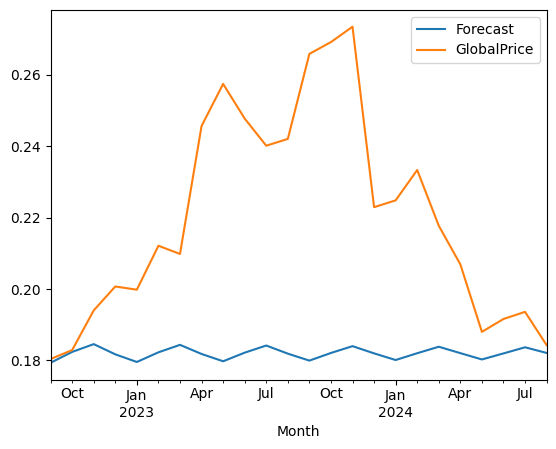

In [46]:
Model(gPrice_train, gPrice_test, (2,1,3))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


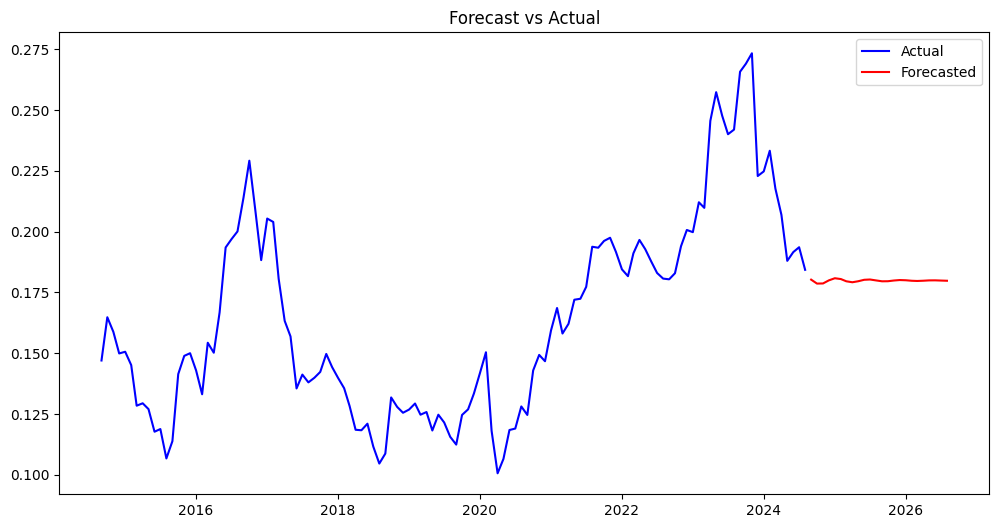

2024-09-01    0.180266
2024-10-01    0.178647
2024-11-01    0.178695
2024-12-01    0.179967
2025-01-01    0.180846
2025-02-01    0.180505
2025-03-01    0.179589
2025-04-01    0.179190
2025-05-01    0.179603
2025-06-01    0.180205
2025-07-01    0.180323
2025-08-01    0.179947
2025-09-01    0.179587
2025-10-01    0.179615
2025-11-01    0.179911
2025-12-01    0.180102
2026-01-01    0.180014
2026-02-01    0.179804
2026-03-01    0.179720
2026-04-01    0.179821
2026-05-01    0.179957
2026-06-01    0.179978
2026-07-01    0.179889
2026-08-01    0.179809
Freq: MS, Name: Forecast, dtype: float64

In [47]:
forecast, model = Forecast(globalPrice, (2,1,3), 24)
Forecasted_plot(globalPrice, forecast)
forecast

# Exchange Rate

<Axes: xlabel='Month'>

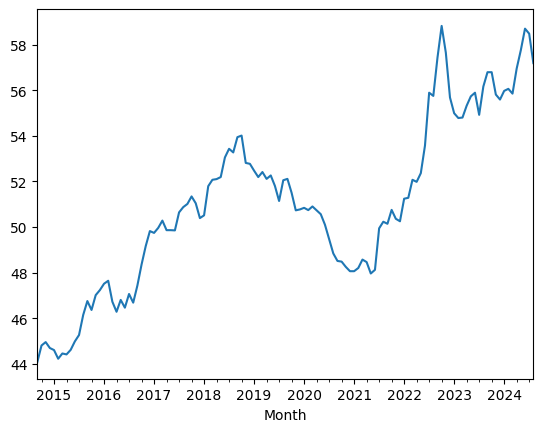

In [48]:
exchangeRate.plot()

In [49]:
ADF_test(exchangeRate)

P-value: 0.6363739272671771 < 0.05
The time series is not stationary


P-value: 4.629212138886278e-13 < 0.05
The time series is stationary


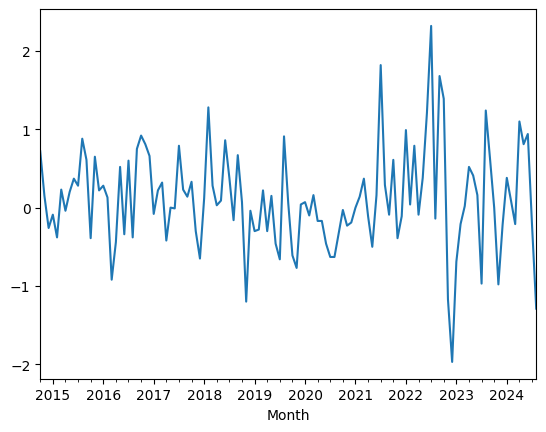

In [50]:
Differencing(exchangeRate, 1)

In [51]:
eRate_train, eRate_test = train_test_split(exchangeRate, 24)
ADF_test(eRate_train)

P-value: 0.8072736145790143 < 0.05
The time series is not stationary


P-value: 4.3559251889283095e-12 < 0.05
The time series is stationary


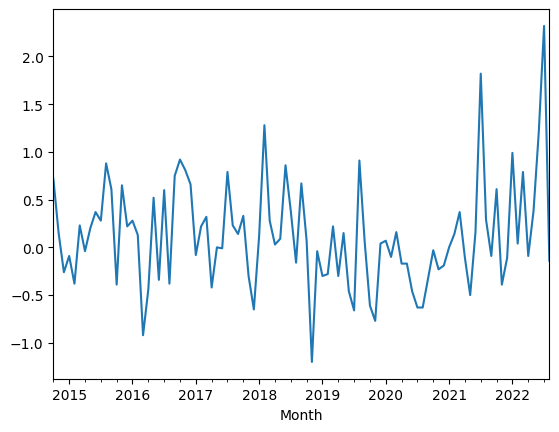

In [52]:
Differencing(eRate_train, 1)

In [53]:
Order_RMSE(eRate_train, eRate_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(eRate_train, eRate_test, range(0, 5), range(0, 2), range(0, 5))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(3, 1, 0) RMSE=1.2456261126322883


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(4, 1, 4) AIC=156.74981392656102


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Actual: 57.43, Predicted: 55.81314117117575
Actual: 58.82, Predicted: 56.440698185947134
Actual: 57.65, Predicted: 57.0179884315394
Actual: 55.68, Predicted: 57.4403945741154
Actual: 54.99, Predicted: 58.2312888887731
Actual: 54.78, Predicted: 58.585419565958254
Actual: 54.8, Predicted: 59.42511938080547
Actual: 55.32, Predicted: 59.762012399226016
Actual: 55.73, Predicted: 60.56263519648894
Actual: 55.89, Predicted: 60.89173814401639
Actual: 54.92, Predicted: 61.60893311825683
Actual: 56.16, Predicted: 61.92227729753293
Actual: 56.79, Predicted: 62.536421394515266
Actual: 56.79, Predicted: 62.821245276695365
Actual: 55.81, Predicted: 63.326885942419025
Actual: 55.59, Predicted: 63.571719669871186
Actual: 55.97, Predicted: 63.97161651887803
Actual: 56.06, Predicted: 64.16875297093088
Actual: 55.85, Predicted: 64.47044867989925
Actual: 56.95, Predicted: 64.61649381461571
Actual: 57.76, Predicted: 64.83026171046907
Actual: 58.7, Predicted: 64.92573226699258
Actual: 58.48, Predicted: 65.0

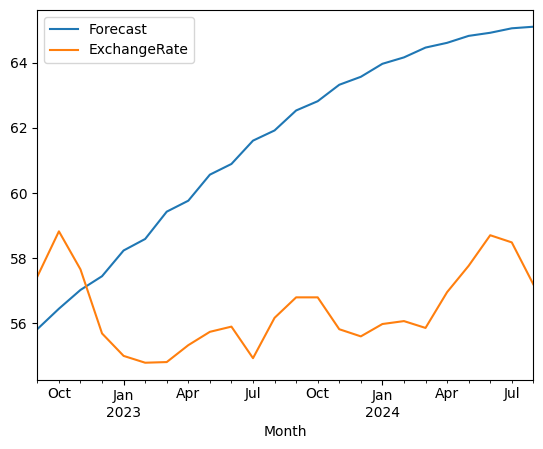

In [54]:
Model(eRate_train, eRate_test, (4,1,4))

Actual: 57.43, Predicted: 55.72817770869475
Actual: 58.82, Predicted: 56.143502593371416
Actual: 57.65, Predicted: 56.22468211079373
Actual: 55.68, Predicted: 56.20536381154308
Actual: 54.99, Predicted: 56.2667007887619
Actual: 54.78, Predicted: 56.29802107630572
Actual: 54.8, Predicted: 56.29717144464546
Actual: 55.32, Predicted: 56.305065379061105
Actual: 55.73, Predicted: 56.31263238464464
Actual: 55.89, Predicted: 56.313696522679045
Actual: 54.92, Predicted: 56.3147014375389
Actual: 56.16, Predicted: 56.31619437611146
Actual: 56.79, Predicted: 56.31666894923098
Actual: 56.79, Predicted: 56.316836114373636
Actual: 55.81, Predicted: 56.31710007362489
Actual: 55.59, Predicted: 56.31723534722542
Actual: 55.97, Predicted: 56.31727590943926
Actual: 56.06, Predicted: 56.317320906938676
Actual: 55.85, Predicted: 56.31735250634075
Actual: 56.95, Predicted: 56.31736368411665
Actual: 57.76, Predicted: 56.31737168608784
Actual: 58.7, Predicted: 56.317378292737004
Actual: 58.48, Predicted: 56.3

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


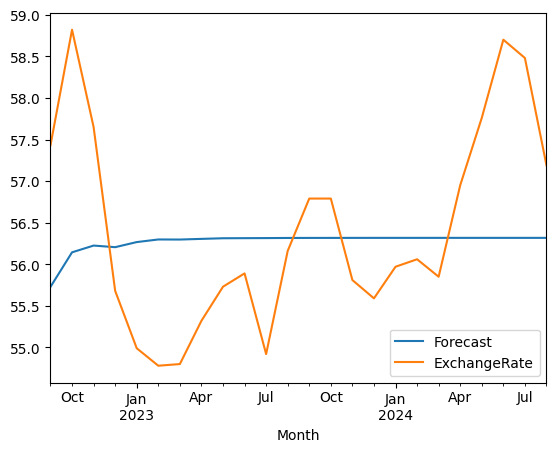

In [55]:
Model(eRate_train, eRate_test, (3,1,0))

In [56]:
Evaluate(eRate_train, eRate_test, (4,1,4))
Evaluate(eRate_train, eRate_test, (3,1,0))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Evaluation of ARIMA(4, 1, 4)
MSE: 35.47990717167664
MAE: 5.510942892812937
RMSE: 5.956501252553939
MAPE: 9.77786837566012
AIC: 156.74981392656102
BIC: 179.7347059509659
Evaluation of ARIMA(3, 1, 0)
MSE: 1.5515844124714262
MAE: 1.0378786166122387
RMSE: 1.2456261126322883
MAPE: 1.8269734475725812
AIC: 162.19615412477194
BIC: 172.4116616911741


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


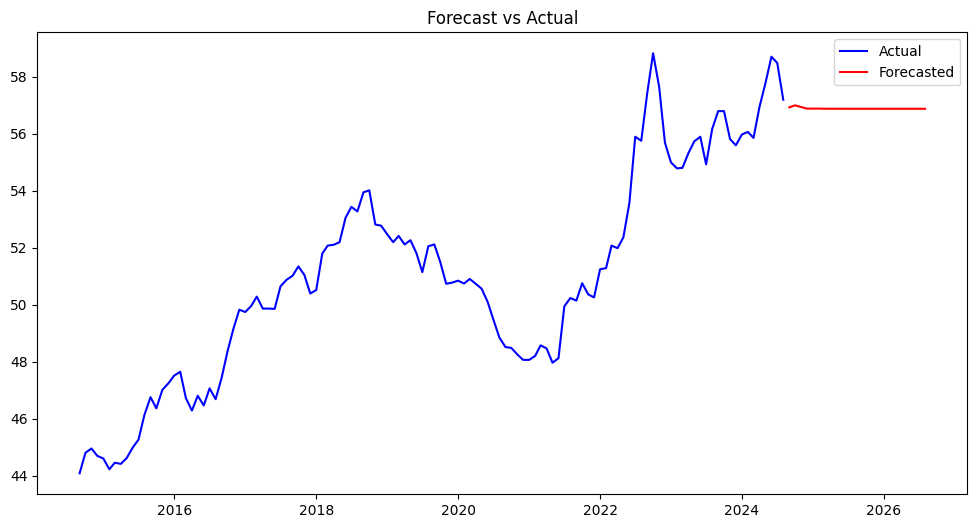

In [57]:
forecast, model = Forecast(exchangeRate, (3,1,0), 24)
Forecasted_plot(exchangeRate, forecast)

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


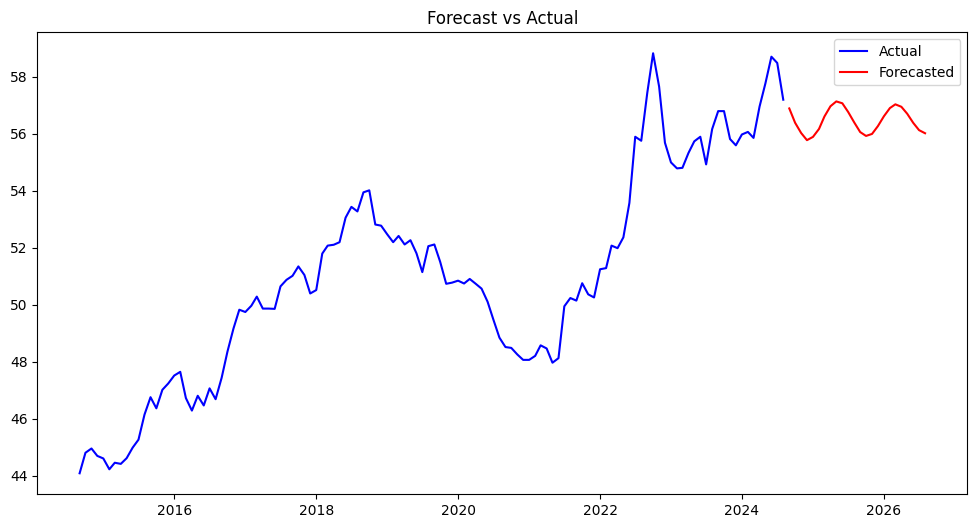

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           ExchangeRate   No. Observations:                  120
Model:                 ARIMA(4, 1, 4)   Log Likelihood                -106.944
Date:                Mon, 28 Apr 2025   AIC                            231.888
Time:                        16:19:07   BIC                            256.900
Sample:                    09-01-2014   HQIC                           242.045
                         - 08-01-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0651      0.093     -0.702      0.483      -0.247       0.117
ar.L2          0.8622      0.091      9.456      0.000       0.684       1.041
ar.L3         -0.3550      0.114     -3.123      0.002      -0.578      -0.132
ar.L4         -0.7470      0.105     -7.117      0.000      -0.953      -0.541
ma.L1          0.3170     27.275      0.012      0.991     -53.140      53.774
ma.L2         -0.9109     13.145     -0.069      0.945     -26.675      24.853
ma.L3          0.3025     18.281      0.017      0.987     -35.527      36.132
ma.L4          0.9922     28.869      0.034      0.973     -55.591      57.575
sigma2         0.3319      9.662      0.034      0.973     -18.606      19.270
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 3.27
Prob(Q):                              0.75   Prob(JB):                         0.19
Heteroskedasticity (H):               3.24   Skew:                             0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
forecast, model = Forecast(exchangeRate,(4,1,4), 24)
Forecasted_plot(exchangeRate, forecast)
model.summary()

# Temperature


<Axes: xlabel='Month'>

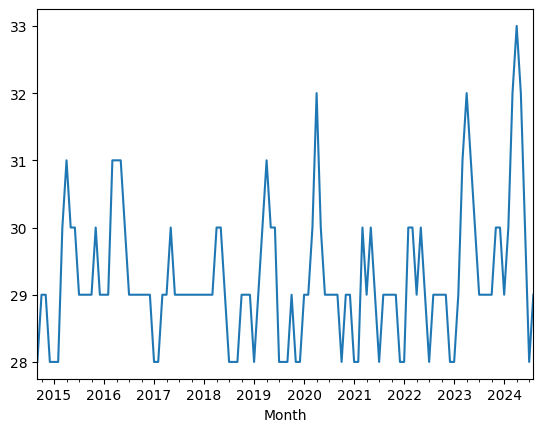

In [59]:
temperature.plot()

In [60]:
ADF_test(temperature)

P-value: 0.8994434774757843 < 0.05
The time series is not stationary


P-value: 0.01324253375192389 < 0.05
The time series is stationary


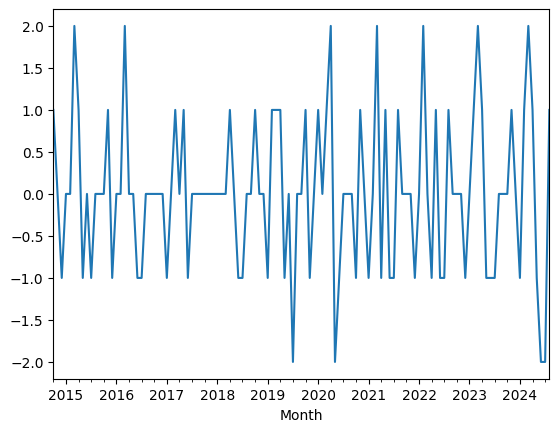

In [61]:
Differencing(temperature, 1)

In [62]:
temp_train, temp_test = train_test_split(temperature, 24)
ADF_test(temp_train)

P-value: 0.23032267138123358 < 0.05
The time series is not stationary


P-value: 6.295159977870521e-10 < 0.05
The time series is stationary


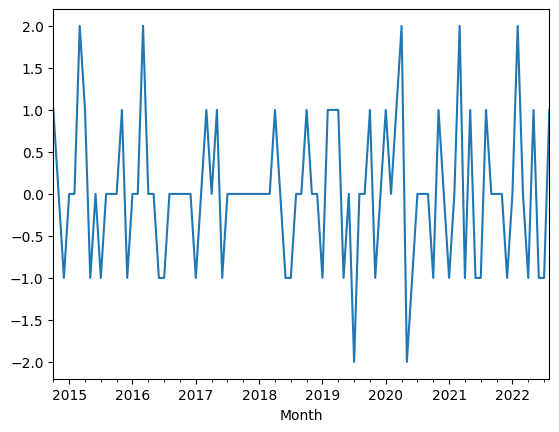

In [63]:
Differencing(temp_train, 1)

In [64]:
Order_RMSE(temp_train, temp_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(temp_train, temp_test, range(0, 5), range(0, 2), range(0, 5))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(3, 0, 3) RMSE=1.3075905608429932


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(3, 1, 4) AIC=210.69260329015344


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [65]:
Evaluate(temp_train, temp_test, (3,0,3))
Evaluate(temp_train, temp_test, (3,1,4))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\stat

Evaluation of ARIMA(3, 0, 3)
MSE: 1.7097930748056933
MAE: 1.0071588780701564
RMSE: 1.3075905608429932
MAPE: 3.2865402948291345
AIC: 214.03468848148668
BIC: 234.54947401322937
Evaluation of ARIMA(3, 1, 4)
MSE: 1.927086593999297
MAE: 1.067194163203313
RMSE: 1.388195445173084
MAPE: 3.4694401261731675
AIC: 210.69260329015344
BIC: 231.12361842295778


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Actual: 29, Predicted: 29.474248860821593
Actual: 29, Predicted: 29.674973440208927
Actual: 29, Predicted: 29.312116987663952
Actual: 28, Predicted: 28.73821305062955
Actual: 28, Predicted: 28.526641512194278
Actual: 29, Predicted: 28.88682360463107
Actual: 31, Predicted: 29.4501543911476
Actual: 32, Predicted: 29.643255580000893
Actual: 31, Predicted: 29.269321508085408
Actual: 30, Predicted: 28.707409127095737
Actual: 29, Predicted: 28.527452977058505
Actual: 29, Predicted: 28.911774014304193
Actual: 29, Predicted: 29.470123300565753
Actual: 29, Predicted: 29.63581302411435
Actual: 30, Predicted: 29.24078900346047
Actual: 30, Predicted: 28.686038251388165
Actual: 29, Predicted: 28.534523438507755
Actual: 30, Predicted: 28.939872180298835
Actual: 32, Predicted: 29.490598959317808
Actual: 33, Predicted: 29.62781551026021
Actual: 32, Predicted: 29.212398762781262
Actual: 30, Predicted: 28.666045223014756
Actual: 28, Predicted: 28.543198938614672
Actual: 29, Predicted: 28.968396666580897

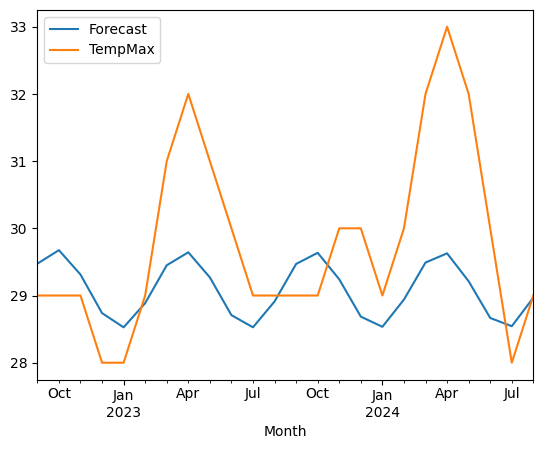

In [66]:
Model(temp_train,temp_test, (3,1,4))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


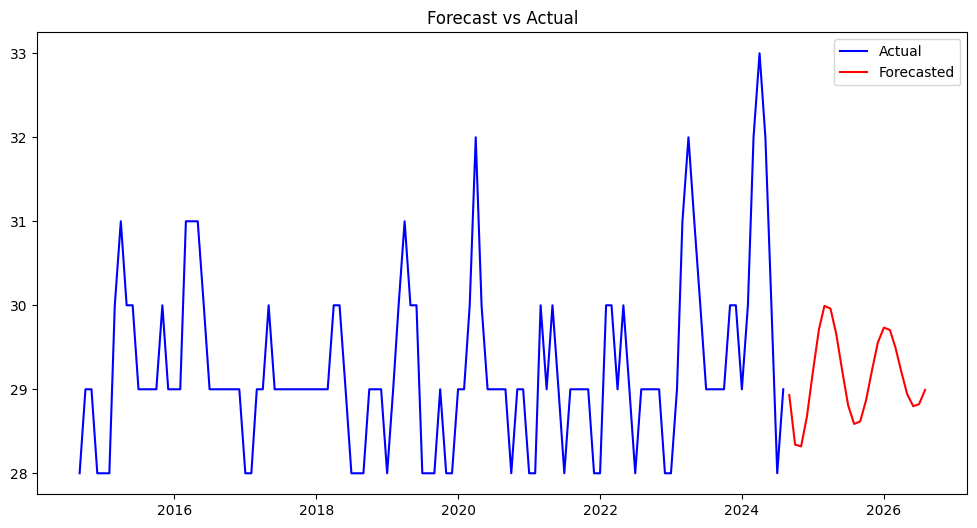

In [67]:
forecast, model = Forecast(temperature, (3,0,3), 24)
Forecasted_plot(temperature, forecast)

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


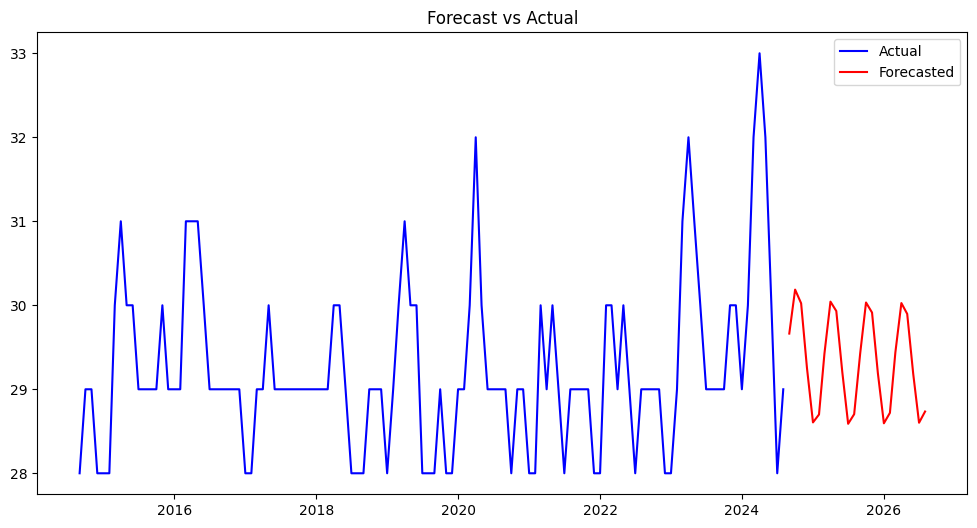

In [68]:
forecast, model = Forecast(temperature, (3,1,4), 24)
Forecasted_plot(temperature, forecast)

# Precipitation

<Axes: xlabel='Month'>

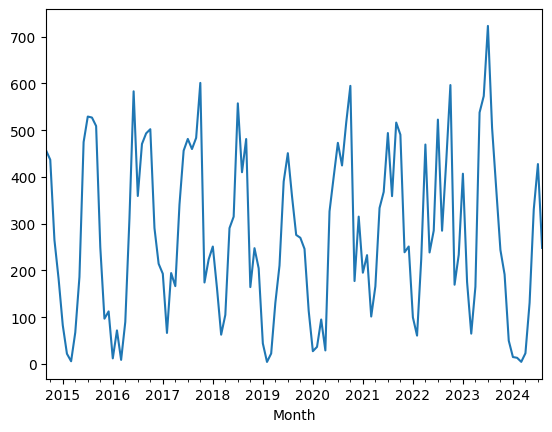

In [69]:
precipitation.plot()

In [70]:
ADF_test(precipitation)

P-value: 0.37821243823258927 < 0.05
The time series is not stationary


P-value: 5.531744325847403e-11 < 0.05
The time series is stationary


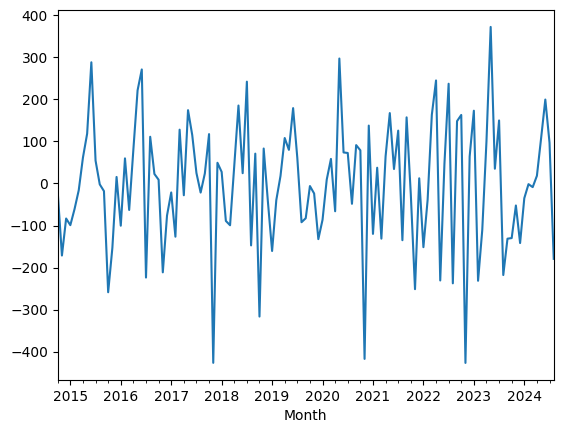

In [71]:
Differencing(precipitation, 1)

In [72]:
perc_train, perc_test = train_test_split(precipitation, 24)
ADF_test(perc_train)

P-value: 0.4801755097758558 < 0.05
The time series is not stationary


P-value: 0.0001667638667513655 < 0.05
The time series is stationary


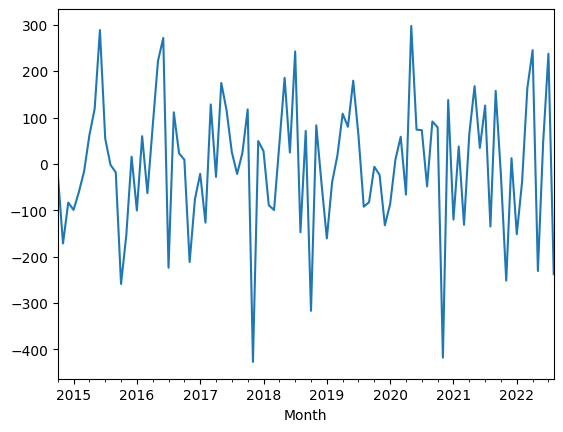

In [73]:
Differencing(perc_train, 1)

In [74]:
Order_RMSE(perc_train, perc_test, range(0, 5), range(0, 2), range(0, 5))
Order_AIC(perc_train, perc_test, range(0, 5), range(0, 2), range(0, 5))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(2, 0, 2) RMSE=146.16832889635367


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\ts

Best ARIMA(4, 1, 4) AIC=1161.5074041957234


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [75]:
Evaluate(perc_train, perc_test, (4,1,4))
Evaluate(perc_train, perc_test, (2,0,2))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\stat

Evaluation of ARIMA(4, 1, 4)
MSE: 22077.875881120188
MAE: 123.94451999864765
RMSE: 148.58625737638118
MAPE: 268.10615082736115
AIC: 1161.5074041957234
BIC: 1184.4922962201283
Evaluation of ARIMA(2, 0, 2)
MSE: 21365.18037235262
MAE: 120.32379794674655
RMSE: 146.16832889635367
MAPE: 230.25150082276068
AIC: 1165.0338167410878
BIC: 1180.4199058898948


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Actual: 433.4, Predicted: 431.0915544218452
Actual: 596.5, Predicted: 351.3657051337808
Actual: 169.5, Predicted: 251.62217412412483
Actual: 233.7, Predicted: 158.63371015312433
Actual: 406.91, Predicted: 97.35813260625068
Actual: 175.4, Predicted: 84.23972921931843
Actual: 64.9, Predicted: 122.79616691994943
Actual: 165.2, Predicted: 202.6752392025066
Actual: 537.8, Predicted: 302.43438036086656
Actual: 572.95, Predicted: 395.2966613799897
Actual: 722.95, Predicted: 456.33814045809976
Actual: 505.1, Predicted: 469.17736983272755
Actual: 373.75, Predicted: 430.3716165582754
Actual: 243.86, Predicted: 350.340001863657
Actual: 191.51, Predicted: 250.5660274313613
Actual: 49.8, Predicted: 157.83059400982023
Actual: 14.83, Predicted: 97.02358743267345
Actual: 13.23, Predicted: 84.46351511820916
Actual: 4.56, Predicted: 123.51818060709405
Actual: 22.9, Predicted: 203.70165623638297
Actual: 130.78, Predicted: 303.489687276382
Actual: 330.53, Predicted: 396.0976097106188
Actual: 427.55, Predi

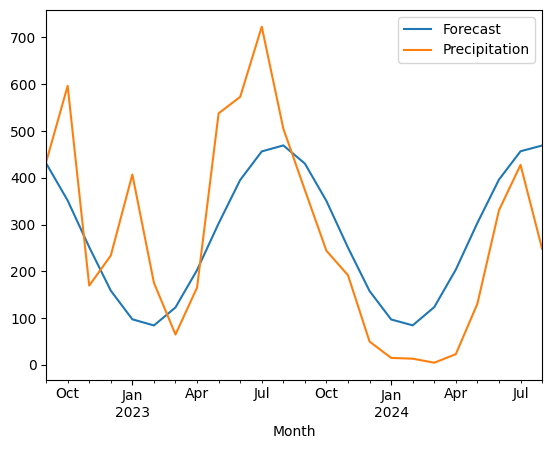

In [76]:
Model(perc_train, perc_test, (2,0,2))

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


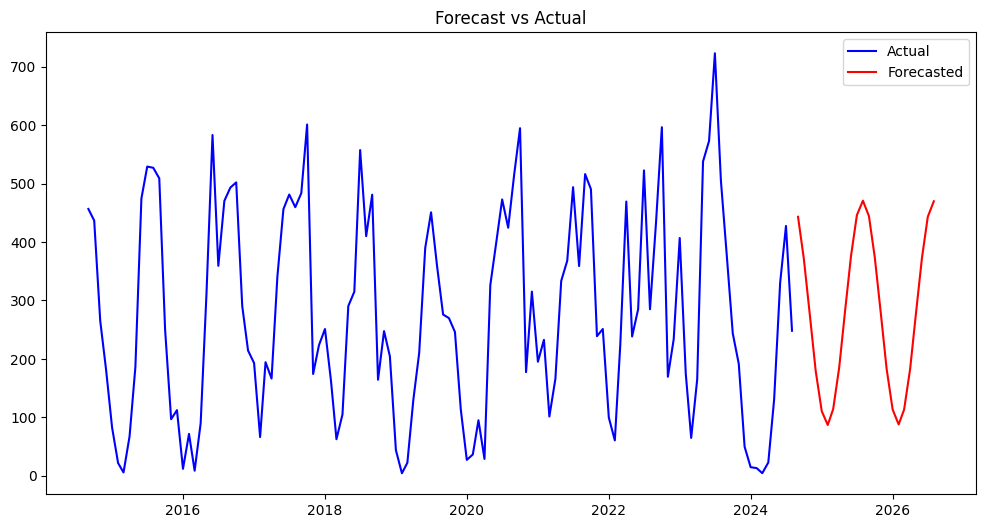

In [77]:
forecast, model = Forecast(precipitation, (2,0,2), 24)
Forecasted_plot(precipitation, forecast)

C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Franniel\AppData\Roaming\Python\Python312\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


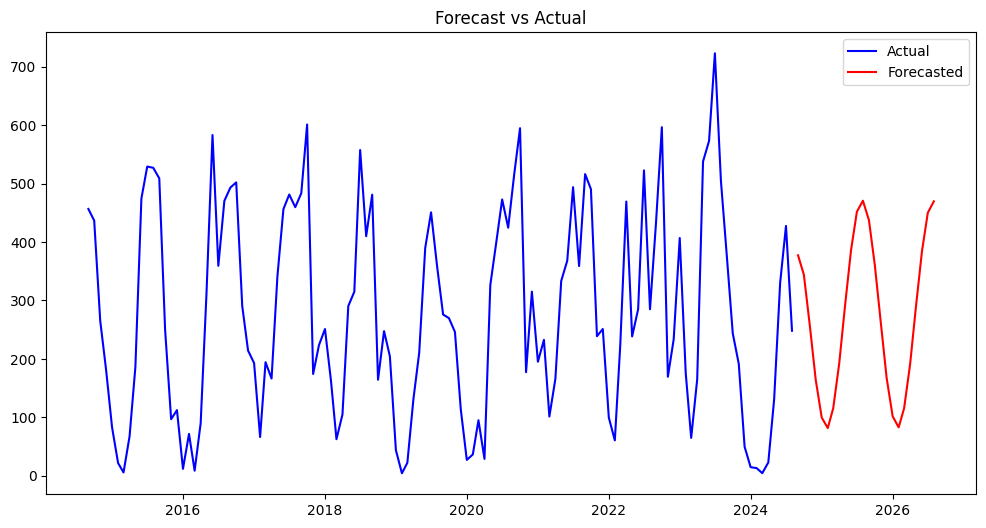

In [78]:
forecast, model = Forecast(precipitation, (4,1,4), 24)
Forecasted_plot(precipitation, forecast)